In [2]:
from scipy.optimize import minimize
import numpy as np
import os
import matplotlib.pyplot as plt

homogenous coordinates as input

In [3]:
def T_matrix(s, delta_x, delta_y, l, r):

    delta = np.sqrt(delta_x**2 + delta_y**2)
    S = np.sin(s * delta / (l * r))
    C = np.cos(s * delta / (l * r))
    
    T11 = 1 + (delta_x**2 / delta**2) * (C - 1)
    T12 = (delta_x * delta_y / delta**2) * (C - 1)
    T13 = -delta_x * S / delta
    T14 = delta_x * l * r * (1 - C) / delta**2
    
    T21 = (delta_y * delta_x / delta**2) * (C - 1)
    T22 = 1 + (delta_y**2 / delta**2) * (C - 1)
    T23 = -delta_y * S / delta
    T24 = delta_y * l * r * (1 - C) / delta**2
    
    T31 = delta_x * S / delta
    T32 = delta_y * S / delta
    T33 = C
    T34 = l * r * S/ delta
    
    T41 = 0
    T42 = 0
    T43 = 0
    T44 = 1
    
    T = np.array([
        [T11, T12, T13, T14],
        [T21, T22, T23, T24],
        [T31, T32, T33, T34],
        [T41, T42, T43, T44]
    ])
    
    return T

def tendon_disp_to_bezier_control_points(delta_x, delta_y, l, r, p0):
    p1 = (2*T_matrix(0.5, delta_x, delta_y, l, r) - T_matrix(0, delta_x, delta_y, l, r) / 2 - T_matrix(1, delta_x, delta_y, l, r) / 2) @ p0
    p2 = T_matrix(1, delta_x, delta_y, l, r) @ p0
    
    return p1, p2

In [4]:
def objective(vars, p0, p1_observed, p2_observed, l, r):
    delta_x, delta_y = vars
    
    p1_computed, p2_computed = tendon_disp_to_bezier_control_points(delta_x, delta_y, l, r, p0)
    
    # 计算残差
    residual_p1 = np.linalg.norm(p1_computed - p1_observed)
    residual_p2 = np.linalg.norm(p2_computed - p2_observed)
    
    return residual_p1 + residual_p2


In [5]:
def bezier_control_points_to_tendon_disp(p0, p1, p2, l, r):
    initial_guess = [0.5, 0.5]
    result = minimize(objective, initial_guess, args=(p0, p1, p2, l, r))
    delta_x_solution, delta_y_solution = result.x
    
    return delta_x_solution, delta_y_solution

In [6]:
l = 2.0  
r = 0.1  
p0 = np.array([0.02, 0.008, 0.054, 1])
delta_x = 0.2
delta_y = 0.3

p1, p2 = tendon_disp_to_bezier_control_points(delta_x, delta_y, l, r, p0)

In [7]:
delta_x_solution, delta_y_solution = bezier_control_points_to_tendon_disp(p0, p1, p2, l, r)

print(f"Solved values for delta_x and delta_y are: {delta_x_solution}, {delta_y_solution}")

Solved values for delta_x and delta_y are: 0.19999999580397806, 0.29999999427073376


Read groundtruth

In [8]:
folder_path = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/data/rendered_images/dof2_64/'
file_name = 'dof2_c0_-0.005_-0.005_0.2_0.01_gt.npy'
file_path = folder_path + file_name

data = np.load(file_path)

print(data)

[[ 0.02        0.002       0.        ]
 [ 0.01919279  0.00119279  0.09826749]
 [-0.03058839 -0.04858839  0.17363909]]


In [9]:


# 提取第2行和第3行
rows = data[1:3, :]

# 将矩阵转换为向量
vector = rows.reshape(-1)

print(vector)


[ 0.01919279  0.00119279  0.09826749 -0.03058839 -0.04858839  0.17363909]


In [10]:
file_path = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts/test_diff_render_catheter_v2/blender_imgs/test_catheter_gt1.npy'
data = np.load(file_path)
print(data)

[[[ 0.02        0.008       0.054     ]
  [ 0.00489567 -0.03695673  0.1961689 ]
  [ 0.02508683  0.01446504  0.1106877 ]
  [ 0.02005205 -0.00052053  0.15807733]]]


In [11]:
import torch
a = torch.tensor(vector, dtype=torch.float, requires_grad=False)

In [12]:
file_name = 'dof2_c48_0.001_-0.005_0.2_0.01_gt.npy'
file_path = folder_path + file_name

data = np.load(file_path)

print(data)

[[ 0.02        0.002       0.        ]
 [ 0.02007997  0.00160014  0.1026283 ]
 [ 0.02973628 -0.04668138  0.19240253]]


test of l and r

In [13]:
# l = 0.2  
# r = 0.01  
# p0 = np.array([0.02, 0.002, 0, 1])
# delta_x = 0.001
# delta_y = -0.005

# p1, p2 = tendon_disp_to_bezier_control_points(delta_x, delta_y, l, r, p0)

# print(p1, p2)

In [14]:
def objective_func(vars, actuation_params, bezier_control_points, p0):
    l, r = vars
    total_residual = 0

    # 遍历所有的数据点
    for i, (delta_x, delta_y) in enumerate(actuation_params):
        p1_observed = np.append(bezier_control_points[i][1], 1)  # 将 p1 转换为齐次坐标
        p2_observed = np.append(bezier_control_points[i][2], 1)  # 将 p2 转换为齐次坐标

        p1_computed, p2_computed = tendon_disp_to_bezier_control_points(delta_x, delta_y, l, r, p0)

        # 计算残差
        residual_p1 = np.linalg.norm(p1_computed - p1_observed)
        residual_p2 = np.linalg.norm(p2_computed - p2_observed)

        total_residual += (residual_p1 + residual_p2)

    return total_residual

In [15]:
def fit_parameters(actuation_params, bezier_control_points, p0):
    initial_guess = [0.1, 0.0015]  # 初始估计值
    bounds = [(0.02, None), (0.0005, None)]
    
    result = minimize(objective_func, initial_guess, args=(actuation_params, bezier_control_points, p0), bounds=bounds)
    l_solution, r_solution = result.x
    
    return l_solution, r_solution

In [16]:
# 指定文件夹路径
folder_path = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/data/rendered_images/dof2_64/'

# 存储提取的数字
actuation_params = []
bezier_control_points = []

# 遍历文件夹中的所有文件
for filename in os.listdir(folder_path):
    if filename.endswith('.npy'):
        print(filename)
        # 分割文件名
        parts = filename.split('_')
        # 提取第三段和第四段的数字
        third_value = float(parts[2])
        fourth_value = float(parts[3])
        actuation_params.append([third_value, fourth_value])
        
        file_path = folder_path + filename
        # print(file_path)
        data = np.load(file_path)
        bezier_control_points.append(data)
        print(data)

dof2_c0_-0.005_-0.005_0.2_0.01_gt.npy
[[ 0.02        0.002       0.        ]
 [ 0.01919279  0.00119279  0.09826749]
 [-0.03058839 -0.04858839  0.17363909]]
dof2_c10_-0.001_-0.0005_0.2_0.01_gt.npy
[[ 0.02        0.002       0.        ]
 [ 0.01999605  0.00199803  0.09905296]
 [ 0.00990552 -0.00304724  0.19748797]]
dof2_c11_-0.001_-0.0001_0.2_0.01_gt.npy
[[0.02       0.002      0.        ]
 [0.01999681 0.00199968 0.09907324]
 [0.0099075  0.00099075 0.1976469 ]]
dof2_c12_-0.001_0.0001_0.2_0.01_gt.npy
[[0.02       0.002      0.        ]
 [0.01999681 0.00200032 0.09909326]
 [0.0099095  0.00300905 0.19768683]]
dof2_c13_-0.001_0.0005_0.2_0.01_gt.npy
[[0.02       0.002      0.        ]
 [0.01999606 0.00200197 0.09915306]
 [0.00991551 0.00704224 0.19768755]]
dof2_c14_-0.001_0.001_0.2_0.01_gt.npy
[[0.02       0.002      0.        ]
 [0.0199937  0.0020063  0.09926488]
 [0.00992681 0.01207319 0.19753999]]
dof2_c15_-0.001_0.005_0.2_0.01_gt.npy
[[0.02       0.002      0.        ]
 [0.01991922 0.00240

In [17]:
# # 输出提取的结果
# for values in actuation_params:
#     print(values)

In [18]:
p_0 = np.array([0.02, 0.002, 0, 1])
l_solution, r_solution = fit_parameters(actuation_params, bezier_control_points, p_0)

In [19]:
print(l_solution, r_solution)

0.02 0.0005


In [20]:
def calculate_error_percentages(l, r, actuation_params, bezier_control_points, p0):
    error_percentages = []
    
    # 遍历所有的数据点
    for i, (delta_x, delta_y) in enumerate(actuation_params):
        p1_observed = np.append(bezier_control_points[i][1], 1)  # 转换为齐次坐标
        p2_observed = np.append(bezier_control_points[i][2], 1)  # 转换为齐次坐标

        p1_computed, p2_computed = tendon_disp_to_bezier_control_points(delta_x, delta_y, l, r, p0)

        # 计算残差
        residual_p1 = np.linalg.norm(p1_computed - p1_observed)
        residual_p2 = np.linalg.norm(p2_computed - p2_observed)
        
        # 计算误差百分比
        error_percentage_p1 = (residual_p1 / np.linalg.norm(p1_observed)) if np.linalg.norm(p1_observed) != 0 else 0
        error_percentage_p2 = (residual_p2 / np.linalg.norm(p2_observed)) if np.linalg.norm(p2_observed) != 0 else 0
        
        error_percentages.append((error_percentage_p1, error_percentage_p2))
    
    return error_percentages

In [21]:
error_percentages = calculate_error_percentages(l_solution, r_solution, actuation_params, bezier_control_points, p0)
print("Error percentages:", error_percentages)

Error percentages: [(0.1763850599228995, 0.21883977836990887), (0.05364146755334699, 0.17758582619134014), (0.04506645760038012, 0.14099973454432022), (0.04513409648076767, 0.141018935683969), (0.060897782510527826, 0.1841967949794693), (0.13672010448630806, 0.24774305061926877), (0.25611216517533614, 0.17545777339969823), (0.04619849313941226, 0.14040643831342586), (0.054719545251369864, 0.18113801348893024), (0.2732204224907277, 0.2040165927779365), (0.051106119007677094, 0.1596150968934697), (0.25803550111904794, 0.18545216750088087), (0.0491191435458157, 0.15735603320736108), (0.2729668497903475, 0.1937315611451944), (0.0692462297037345, 0.19454639269917287), (0.04944086179142276, 0.14112792548214156), (0.10781025387919987, 0.22773696755593356), (0.04593296116371481, 0.14314956998053494), (0.050192016622817345, 0.15572556338033994), (0.046059884865893956, 0.1494594911959289), (0.03901374880680496, 0.13806516991901377), (0.03982108519811942, 0.1442267770459409), (0.04175359625291552

In [22]:
def plot_error_percentages(error_percentages):
    # 提取每组数据的误差百分比
    errors_p1 = [ep[0] for ep in error_percentages]
    errors_p2 = [ep[1] for ep in error_percentages]

    # 创建条形图
    x = range(len(errors_p1))  # 数据点的数量
    width = 0.35  # 条形的宽度

    fig, ax = plt.subplots()
    bars_p1 = ax.bar(x, errors_p1, width, label='Error % for P1')
    bars_p2 = ax.bar([p + width for p in x], errors_p2, width, label='Error % for P2')

    # 添加一些文本描述
    ax.set_xlabel('Data Point Index')
    ax.set_ylabel('Error Percentage')
    ax.set_title('Error Percentages for P1 and P2')
    ax.set_xticks([p + width / 2 for p in x])
    ax.set_xticklabels([str(i) for i in x])
    ax.legend()

    # # 在条形图上添加数字标签
    # def autolabel(bars):
    #     """Attach a text label above each bar in *bars*, displaying its height."""
    #     for bar in bars:
    #         height = bar.get_height()
    #         ax.annotate('%.2f' % height,
    #                     xy=(bar.get_x() + bar.get_width() / 2, height),
    #                     xytext=(0, 3),  # 3 points vertical offset
    #                     textcoords="offset points",
    #                     ha='center', va='bottom')

    # autolabel(bars_p1)
    # autolabel(bars_p2)

    plt.show()

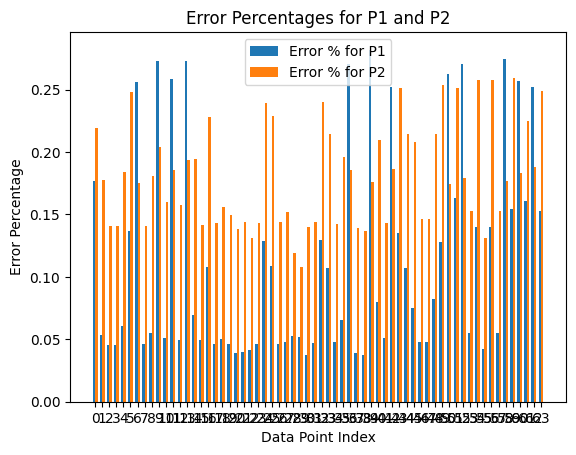

In [23]:
plot_error_percentages(error_percentages)

In [25]:
case_naming = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/data/rendered_images/dof2_64/dof2_c48_0.001_-0.005_0.2_0.01'
img_save_path = case_naming + '.png'
cc_specs_path = case_naming + '_gt.npy'
para_gt_np = np.load(cc_specs_path)[1:3, :].flatten()

print(para_gt_np)

[ 0.02007997  0.00160014  0.1026283   0.02973628 -0.04668138  0.19240253]
